# SysArmy salaries dashboard

## Datasets

| Period  | Path             | URL                                                                                                         |
|---------|------------------|-------------------------------------------------------------------------------------------------------------|
| 2014.02 | data/2014.02.csv | http://sysarmy.com.ar/blog/wp-content/uploads/2015/01/sysarmy-resultados-encuesta-remuneracion-salarial.csv |
| 2015.01 | data/2015.01.csv | http://sysarmy.com.ar/blog/wp-content/uploads/2015/09/sysarmy-encuesta-salarial-julio-2015.csv              |
| 2016.01 | data/2016.01.csv | https://sysarmy.com.ar/blog/wp-content/uploads/2016/02/sysarmy-encuesta-salarial-enero-2016.csv             |
| 2016.02 | data/2016.02/    | https://sysarmy.com.ar/blog/wp-content/uploads/2016/08/encuesta-sueldos-sysarmy-openqube.zip                |
| 2017.01 | data/2017.01/    | https://docs.google.com/spreadsheets/d/1diZG7ruHJ4OgO2-tbnO-ZnhjxjOnYjMVSxl7I-4LT54/edit#gid=1424918437     |
| 2017.02 | -                | -                                                                                                           |

## Data preparation

In [1]:
import pandas as pd
import numpy as np

def getPeriodColumnsDataFrame(period, csv_path, columns_src, columns_dst, transform = None):
    # give a csv_path, extract src columns into dst columns by applying a transform function for a certain period name
    df_src = pd.read_csv(csv_path)
    df_dst = pd.DataFrame(columns=['period']+columns_dst)
    df_dst.period = [period] * len(df_src)
    for i in range(len(columns_src)):
        df_dst[columns_dst[i]] = df_src.get(columns_src[i])
    if transform:
        df_dst = transform(df_src, df_dst);
    return df_dst

def incomeNet2Brute(df_src, df_dst):
    # filter wether net or brute income
    mask = np.array(df_src['Bruto o neto?'].str.contains('Neto'), dtype = bool)
    net_factor = np.array([1.0] * len(df_src));
    # scales up net salary into brute, given Argentina's social security contributions
    net_factor[ mask ] = 1.2048193
    df_dst.salary = net_factor * df_dst['salary']
    return df_dst

src_common_cols = ['Años de experiencia', 'Años en el puesto actual', 'Trabajo de', 'Tecnologías que utilizás']
dst_cols = ['salary', 'yoe', 'yip', 'role', 'stack']

df1 = getPeriodColumnsDataFrame('2014.02', '../data/2014.02.csv', ['Salario bruto mensual (AR$)'] + src_common_cols, dst_cols)
df2 = getPeriodColumnsDataFrame('2015.01', '../data/2015.01.csv', ['Salario bruto mensual (AR$)'] + src_common_cols, dst_cols)
df3 = getPeriodColumnsDataFrame('2016.01', '../data/2016.01.csv', ['Salario mensual (AR$)'] + src_common_cols, dst_cols)
df4 = getPeriodColumnsDataFrame('2016.02', '../data/2016.02/argentina.csv', ['Salario mensual (en tu moneda local)'] + src_common_cols, dst_cols, incomeNet2Brute)
df5 = getPeriodColumnsDataFrame('2017.01', '../data/2017.01/argentina.csv', ['Salario mensual (en tu moneda local)'] + src_common_cols, dst_cols, incomeNet2Brute)

def munge(df):
    # cast to float the salary column, some datasets gets wrongly parsed due to crappy user input
    df.salary = df.salary.apply(lambda x: float(x))
    # discard out of range salaries (arbitrary range)
    df = df.loc[(df.salary > 5000) & (df.salary < 300000)]
    # compute mean and std
    mu, sigma = np.mean(df.salary), np.std(df.salary)
    return df

df = munge(pd.concat([df1, df2, df3, df4, df5]))
df[:10]

,period,salary,yoe,yip,role,stack
0,2014.02,21000.00,5 - 7,Menos de un año,SysAdmin,"Linux, """"""Cloud"""""""
1,2014.02,10000.00,10+,2 - 4,SysAdmin,Linux
2,2014.02,16000.00,3 - 5,1 - 2,DevOps,"Linux, """"""Cloud"""""""
3,2014.02,23771.13,5 - 7,1 - 2,SysAdmin,Linux
4,2014.02,16000.00,10+,2 - 4,DevOps,Linux
5,2014.02,17000.00,7 - 10,1 - 2,PM,NaN
6,2014.02,17250.00,5 - 7,6 - 10,Networking,NaN
7,2014.02,11000.00,7 - 10,2 - 4,Otro,NaN
8,2014.02,19176.00,5 - 7,1 - 2,Infosec,NaN
9,2014.02,9600.00,3 - 5,Menos de un año,DevOps,Linux


In [2]:
import scipy.stats as sps
import matplotlib.pyplot as plt
from scipy.misc import logsumexp
%matplotlib inline

## Histogram of Incomes by period (Argentina)

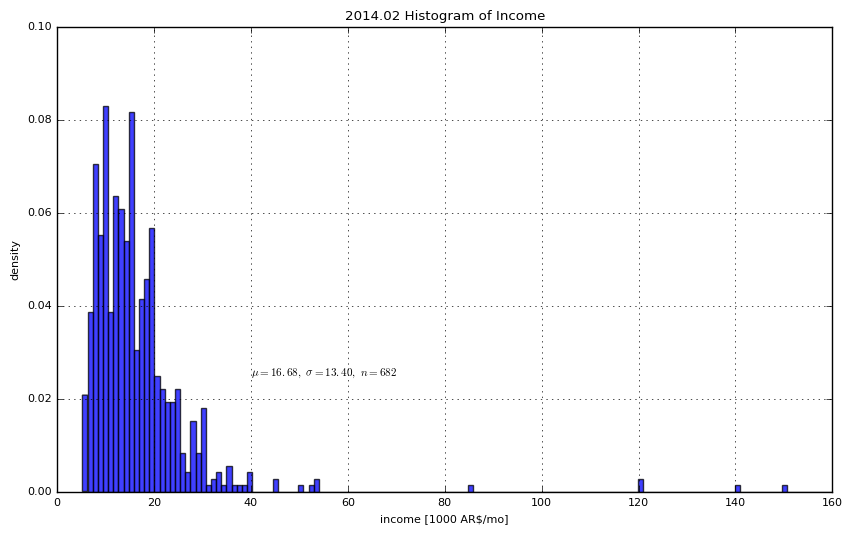

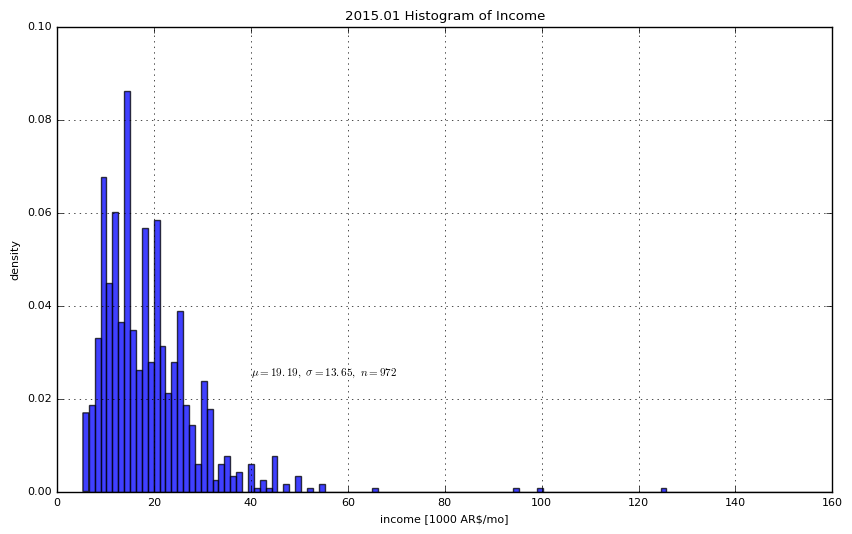

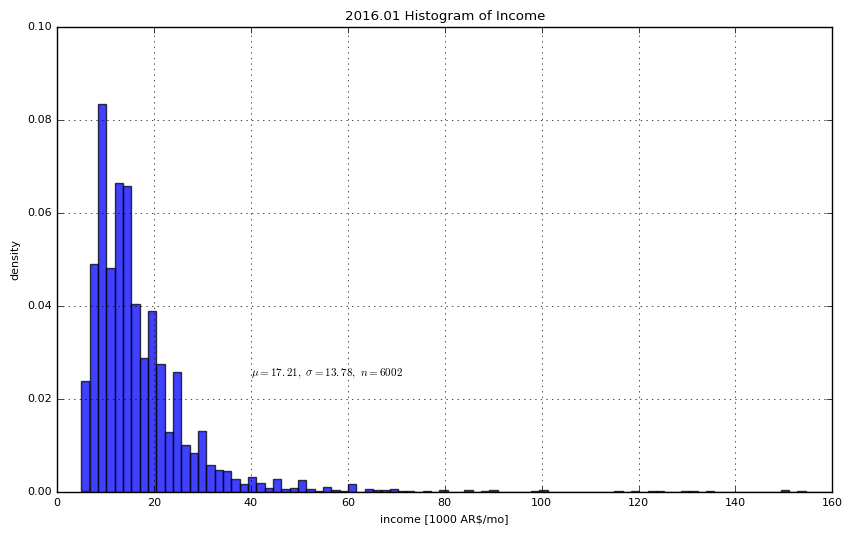

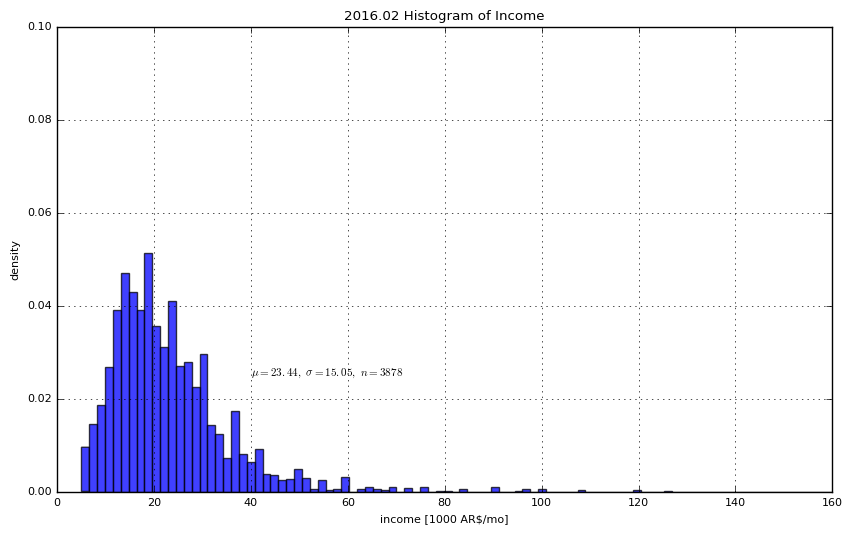

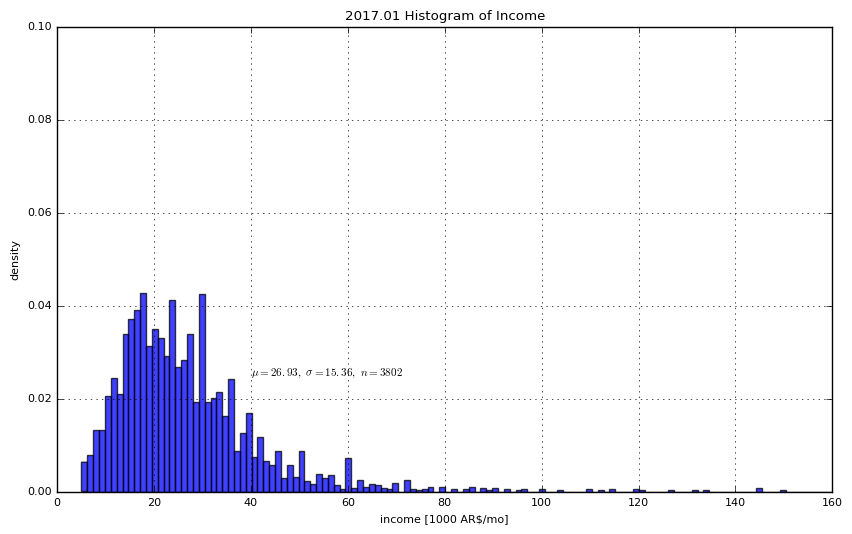

In [3]:
plt.rcParams.update({'figure.figsize': (10.0, 6.0), 'font.size': 8})

def getPlotCurrencyParams(currencySeries):
    s = currencySeries.apply(lambda x: float('{0:.2f}'.format(round(x/1000, 1))))
    mu, sigma = np.mean(s), np.std(s)
    t = np.linspace(mu - 3*sigma, mu + 3*sigma, 1000)
    d = sigma**2/mu
    return mu, sigma, t, d, s

for period in df.period.unique():
    dft = df[df.period.str.contains(period)]
    mu, sigma, t, d, s = getPlotCurrencyParams(dft.salary)
    n, bins, patches = plt.hist(s, 160, normed=1, alpha=0.75)
    plt.xlabel('income [1000 AR$/mo]')
    plt.ylabel('density')
    plt.title(period + ' Histogram of Income')
    plt.text(40, .025, '$\mu=%.2f,\ \sigma=%.2f,\ n=%d$' % (mu, sigma, len(s)))
    plt.axis([0, 160, 0, 0.1])
    plt.grid(True)
    plt.show()

## Median and Standard deviation evolution

Note that in `2016.01`, the median seems to be abnormal.  We're pending to check the data integrity, but as for the histogram, it looks legit.  Perhaps this singularity has to do with the contraction of the economy caused by the persidential elections and the economy uncertainty.

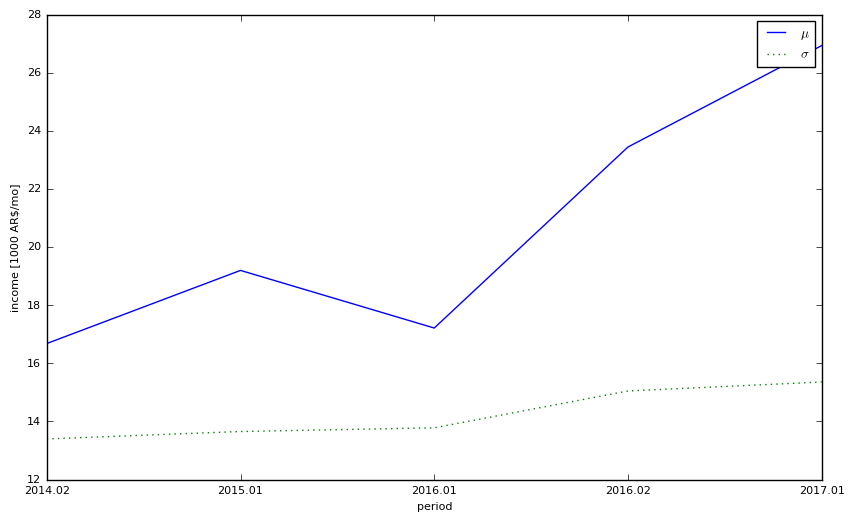

In [4]:
plt.clf()
mus, sigmas = [], []
for period in df.period.unique():
    dft = df[df.period.str.contains(period)]
    mu, sigma, t, d, s = getPlotCurrencyParams(dft.salary)
    mus.append(mu)
    sigmas.append(sigma)

plt.plot(range(len(mus)), mus, label='$\mu$', ls='-')
plt.plot(range(len(sigmas)), sigmas, label='$\sigma$', ls=':')
plt.xlabel('period'); plt.ylabel('income [1000 AR$/mo]')
plt.axes().set_xticklabels(df.period.unique())
plt.axes().set_xticks(range(len(df.period.unique())))
plt.legend()

## Distribution of Income by period (Argentina)

### Assuming Normal distribution

* Probability density function 
 
$$
\large 
p(x \mid \mu, \sigma^2) = \Norm(x \mid \mu, \sigma^2) = \frac{1}{\sqrt{2\pi\sigma^2}} \e\left\{ \frac{-(x - \mu)^2}{2\sigma^2} \right\}
$$
 
* Gaussian density paramters 
 
$$
\large 
\begin{align} 
\mu &= \frac{1}{N} \sum_i x_i \\ 
\sigma^2 &= \frac{1}{N} \sum_i x_i^2 
\end{align} 
$$

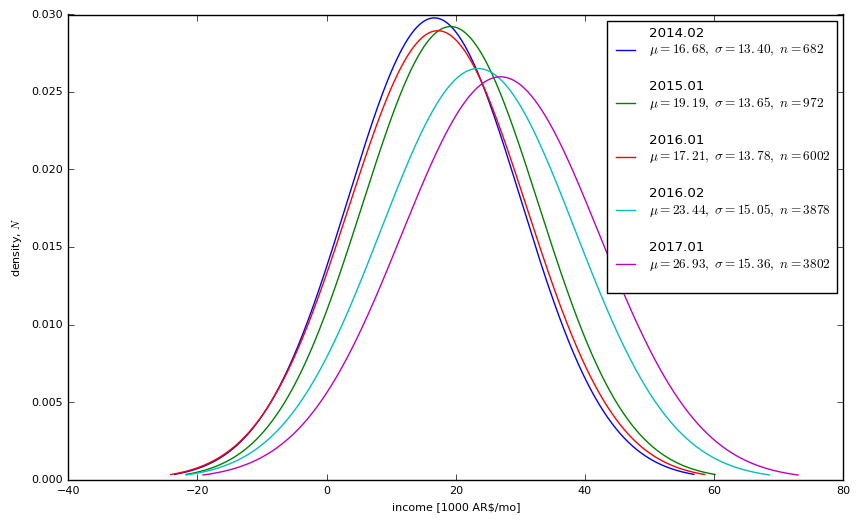

In [5]:
plt.clf()
for period in df.period.unique():
    dft = df[df.period.str.contains(period)]
    mu, sigma, t, d, s = getPlotCurrencyParams(dft.salary)
    plt.plot(t, sps.norm.pdf(t, mu, sigma), label=period + '\n$\mu=%.2f,\ \sigma=%.2f,\ n=%d$\n' % (mu, sigma, len(s)), ls='-')
plt.xlabel('income [1000 AR$/mo]'); plt.ylabel('density, $N$')
plt.legend()

## Interactive Dashboard

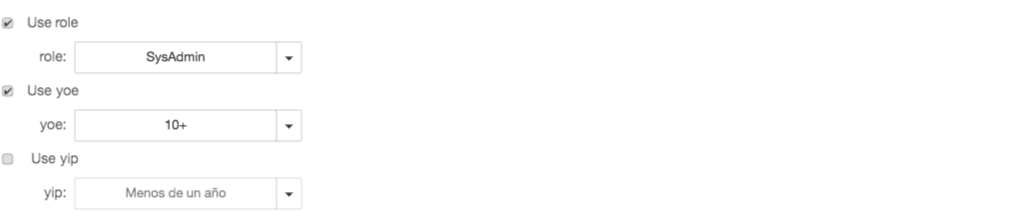

<IPython.core.display.Javascript object>


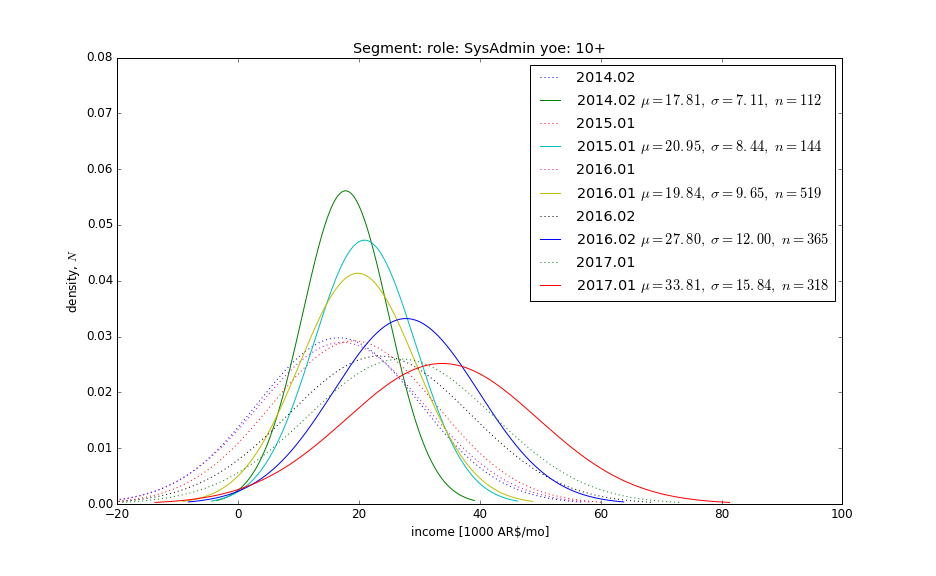

In [49]:
%matplotlib notebook
from IPython.display import clear_output
import ipywidgets as widgets

filters = ['role', 'yoe', 'yip']
i_filters = [{'name': r, 'i': i} for i, r in enumerate(filters)]
filters_opts = list(map(lambda r: list(df[r].unique()), filters))
filters_checkboxes = list(map(lambda r: widgets.Checkbox(value=False, description='Use '+r, name='use_'+r, disabled=False), filters))
filters_dropdowns = list(map(lambda r: widgets.Dropdown(options=filters_opts[r['i']], value=filters_opts[r['i']][0], name=r['name'], description=r['name']+':', disabled=not filters_checkboxes[r['i']].value), i_filters))

plt.rcParams.update({'figure.figsize': (13.0, 8.0), 'font.size': 12})
periods = df.period.unique()
fig, ax = plt.subplots()
ax.set_xlim(-20,100)
ax.set_ylim(0,0.08)
ax.set_xlabel('income [1000 AR$/mo]'); ax.set_ylabel('density, $N$')

def on_filters_change(change):
    for i in range(len(filters)):
        checkbox = filters_checkboxes[i]
        dropdown = filters_dropdowns[i]
        if change['owner'].name == checkbox.name:
            dropdown.disabled = not change['new']
            break
    plot_filtered_monthly_income()

def plot_filtered_monthly_income(change = None):
    if not ax.lines:
        for i in range(len(periods)):
            period = periods[i]
            dft = df[df.period.str.contains(period)]
            mu, sigma, t, d, s = getPlotCurrencyParams(dft.salary)            
            ax.plot(t, sps.norm.pdf(t, mu, sigma), label=period, ls=':')
            ax.plot(t, sps.norm.pdf(t, mu, sigma), label=period + ' $\mu=%.2f,\ \sigma=%.2f,\ n=%d$' % (mu, sigma, len(s)), ls='-')
    else:
        for i in range(len(periods)):
            period = periods[i]
            dft = df[df.period.str.contains(period)]
            for dropdown in filters_dropdowns:
                if not dropdown.disabled:
                    dft = dft[dft[dropdown.name].str.contains(dropdown.value)]
            mu, sigma, t, d, s = getPlotCurrencyParams(dft.salary)
            line = ax.lines[2*i+1]
            if len(dft) > 2:
                line.set_xdata(t)
                line.set_ydata(sps.norm.pdf(t, mu, sigma))
                line.set_label(period + ' $\mu=%.2f,\ \sigma=%.2f,\ n=%d$' % (mu, sigma, len(s)))
            else:
                line.set_xdata([])
                line.set_ydata([])
    title = 'Segment:' + ''.join([
        '' if dropdown.disabled else ' %s: %s' % (dropdown.name, dropdown.value)
            for dropdown in filters_dropdowns])
    plt.title(title)
    ax.legend()
    fig.canvas.draw()


boxes = []
for i in range(len(filters_dropdowns)):
    filters_checkboxes[i].observe(on_filters_change, names='value')
    filters_dropdowns[i].observe(plot_filtered_monthly_income, names='value')
    boxes.append(widgets.Box([filters_checkboxes[i], filters_dropdowns[i]]))
    
plot_filtered_monthly_income()
widgets.Box(boxes)